# This is demo for FL with Pysyft
### author:Andy  2019/6/06

>I am going to use Fashion-MNIST dataset to do Fedreated learning.

>Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image

> https://github.com/zalandoresearch/fashion-mnist

![jupyter](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

##  Import the pacakage and download the F_Mnist data

In [1]:
import torch
from torchvision import datasets, transforms, models
import viewer

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3,1,1)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download the data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Let's see the each image

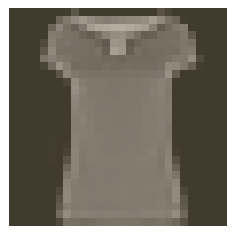

In [2]:
image, label = next(iter(testloader))
viewer.imshow(image[0,:]);

In [3]:
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets,transforms

### import syft and we hook PyTorch:

In [4]:
import syft as sy  
hook = sy.TorchHook(torch)  

### And then create the 8 VirtualWorkers:

In [5]:
andy1 = sy.VirtualWorker(hook, id="andy1")  
andy2 = sy.VirtualWorker(hook, id="andy2") 
andy3 = sy.VirtualWorker(hook, id="andy3") 
andy4 = sy.VirtualWorker(hook, id="andy4") 
andy5 = sy.VirtualWorker(hook, id="andy5") 
andy6 = sy.VirtualWorker(hook, id="andy6") 
andy7 = sy.VirtualWorker(hook, id="andy7") 
andy8 = sy.VirtualWorker(hook, id="andy8") 

### Test the sending data to each worker

In [6]:
x = torch.Tensor([1,2,3]).send(andy1)
print(x)

(Wrapper)>[PointerTensor | me:78411624019 -> andy1:70156509519]


In [7]:
print(x.location)

<VirtualWorker id:andy1 #tensors:1>


In [8]:
y = torch.Tensor([1,2,3]).send(andy1)
print(y)

(Wrapper)>[PointerTensor | me:34047317239 -> andy1:29782564284]


In [9]:
sum_=x+y

In [10]:
sum_

(Wrapper)>[PointerTensor | me:46301125077 -> andy1:46301125077]

In [11]:
sum_.get()

tensor([2., 4., 6.])

In [12]:
x.get()

tensor([1., 2., 3.])

In [13]:
y.get()

tensor([1., 2., 3.])

### Send data to each worker, so that we can do the federated learning later:

In [14]:
federated_train_loader = sy.FederatedDataLoader(trainset.federate((andy1, andy2,andy3,andy4,andy5,andy6,andy7,andy8)), 
                                                batch_size=64, shuffle=True)

Scanning and sending data to andy1, andy2, andy3, andy4, andy5, andy6, andy7, andy8...
Done!


# Build a CNN

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [16]:
model = Net()
criterion = nn.NLLLoss()

# momentum=0.9
## we will use the SGD
optimizer = optim.SGD(model.parameters(), lr=0.0038)

In [18]:
epochs = 3
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    model.train()
    for ii, (data, targets) in enumerate(federated_train_loader):
        
        ## Send model to current worker
        model.send(data.location)
        
        steps += 1
        optimizer.zero_grad()  
        # forward 
        output = model(data)
        
        loss = criterion(output, targets)
        # backward
        loss.backward()
        optimizer.step()
        
        # Get the model back to the local worker, we need to get the model back before sending to another worker
        model.get()
        
        print(loss.data)
        running_loss += loss.data.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in testloader:
                    output = model(data)
                    test_loss += criterion(output, target).data.item()# sum up batch loss
                    pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(testloader.dataset)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    e, ii * 64, len(federated_train_loader) * 64,
                    100. * ii / len(federated_train_loader), loss.item()))
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    test_loss, correct, len(testloader.dataset),
                    100. * correct / len(testloader.dataset)))
                       
            running_loss = 0

(Wrapper)>[PointerTensor | me:47828560030 -> andy1:47828560030]::data
(Wrapper)>[PointerTensor | me:70845827896 -> andy1:70845827896]::data
(Wrapper)>[PointerTensor | me:88159711735 -> andy1:88159711735]::data
(Wrapper)>[PointerTensor | me:29304616458 -> andy1:29304616458]::data
(Wrapper)>[PointerTensor | me:83741133527 -> andy1:83741133527]::data
(Wrapper)>[PointerTensor | me:12990049201 -> andy1:12990049201]::data
(Wrapper)>[PointerTensor | me:69475935971 -> andy1:69475935971]::data
(Wrapper)>[PointerTensor | me:43876893962 -> andy1:43876893962]::data
(Wrapper)>[PointerTensor | me:34466553987 -> andy1:34466553987]::data
(Wrapper)>[PointerTensor | me:90031398233 -> andy1:90031398233]::data
(Wrapper)>[PointerTensor | me:1928799419 -> andy1:1928799419]::data
(Wrapper)>[PointerTensor | me:22442610145 -> andy1:22442610145]::data
(Wrapper)>[PointerTensor | me:94666280584 -> andy1:94666280584]::data
(Wrapper)>[PointerTensor | me:75215539772 -> andy1:75215539772]::data
(Wrapper)>[PointerTens

(Wrapper)>[PointerTensor | me:91604816853 -> andy1:91604816853]::data
(Wrapper)>[PointerTensor | me:25377000529 -> andy1:25377000529]::data
(Wrapper)>[PointerTensor | me:1217901129 -> andy1:1217901129]::data
(Wrapper)>[PointerTensor | me:2867136900 -> andy1:2867136900]::data
(Wrapper)>[PointerTensor | me:61579940529 -> andy2:61579940529]::data
(Wrapper)>[PointerTensor | me:70665520757 -> andy2:70665520757]::data
Train Epoch: 0 [7616/60032 (13%)]	Loss: 1.115951

Test set: Average loss: 0.0189, Accuracy: 6339/10000 (63%)

(Wrapper)>[PointerTensor | me:2275417520 -> andy2:2275417520]::data
(Wrapper)>[PointerTensor | me:50977097636 -> andy2:50977097636]::data
(Wrapper)>[PointerTensor | me:69744758585 -> andy2:69744758585]::data
(Wrapper)>[PointerTensor | me:91649419824 -> andy2:91649419824]::data
(Wrapper)>[PointerTensor | me:43776531715 -> andy2:43776531715]::data
(Wrapper)>[PointerTensor | me:95942092233 -> andy2:95942092233]::data
(Wrapper)>[PointerTensor | me:8945995258 -> andy2:894599

(Wrapper)>[PointerTensor | me:89767060095 -> andy2:89767060095]::data
(Wrapper)>[PointerTensor | me:75261433993 -> andy2:75261433993]::data
(Wrapper)>[PointerTensor | me:48821502374 -> andy2:48821502374]::data
(Wrapper)>[PointerTensor | me:26762653811 -> andy2:26762653811]::data
(Wrapper)>[PointerTensor | me:87926312316 -> andy2:87926312316]::data
(Wrapper)>[PointerTensor | me:6482589958 -> andy2:6482589958]::data
(Wrapper)>[PointerTensor | me:40249360357 -> andy2:40249360357]::data
(Wrapper)>[PointerTensor | me:96394129812 -> andy2:96394129812]::data
(Wrapper)>[PointerTensor | me:2696859891 -> andy2:2696859891]::data
(Wrapper)>[PointerTensor | me:78926362551 -> andy2:78926362551]::data
(Wrapper)>[PointerTensor | me:6156273019 -> andy3:6156273019]::data
(Wrapper)>[PointerTensor | me:17652664001 -> andy3:17652664001]::data
(Wrapper)>[PointerTensor | me:36535926230 -> andy3:36535926230]::data
(Wrapper)>[PointerTensor | me:68822802434 -> andy3:68822802434]::data
Train Epoch: 0 [15296/6003

(Wrapper)>[PointerTensor | me:23120041755 -> andy3:23120041755]::data
(Wrapper)>[PointerTensor | me:83896187657 -> andy3:83896187657]::data
(Wrapper)>[PointerTensor | me:18307886166 -> andy3:18307886166]::data
(Wrapper)>[PointerTensor | me:74787648748 -> andy3:74787648748]::data
(Wrapper)>[PointerTensor | me:68236327503 -> andy3:68236327503]::data
(Wrapper)>[PointerTensor | me:22895655061 -> andy3:22895655061]::data
(Wrapper)>[PointerTensor | me:43334954853 -> andy3:43334954853]::data
(Wrapper)>[PointerTensor | me:26078693256 -> andy3:26078693256]::data
(Wrapper)>[PointerTensor | me:21091861391 -> andy3:21091861391]::data
(Wrapper)>[PointerTensor | me:34988321541 -> andy3:34988321541]::data
(Wrapper)>[PointerTensor | me:20092266010 -> andy3:20092266010]::data
(Wrapper)>[PointerTensor | me:11955924649 -> andy3:11955924649]::data
(Wrapper)>[PointerTensor | me:22543394266 -> andy3:22543394266]::data
(Wrapper)>[PointerTensor | me:14921639482 -> andy3:14921639482]::data
(Wrapper)>[PointerTe

(Wrapper)>[PointerTensor | me:73772136022 -> andy4:73772136022]::data
(Wrapper)>[PointerTensor | me:73848597227 -> andy4:73848597227]::data
(Wrapper)>[PointerTensor | me:57282319953 -> andy4:57282319953]::data
(Wrapper)>[PointerTensor | me:10423171940 -> andy4:10423171940]::data
(Wrapper)>[PointerTensor | me:67751638513 -> andy4:67751638513]::data
(Wrapper)>[PointerTensor | me:38623614276 -> andy4:38623614276]::data
(Wrapper)>[PointerTensor | me:25042309113 -> andy4:25042309113]::data
(Wrapper)>[PointerTensor | me:11065999393 -> andy4:11065999393]::data
(Wrapper)>[PointerTensor | me:23305420230 -> andy4:23305420230]::data
(Wrapper)>[PointerTensor | me:37429564155 -> andy4:37429564155]::data
(Wrapper)>[PointerTensor | me:46647007724 -> andy4:46647007724]::data
(Wrapper)>[PointerTensor | me:66405924869 -> andy4:66405924869]::data
(Wrapper)>[PointerTensor | me:5138114893 -> andy4:5138114893]::data
(Wrapper)>[PointerTensor | me:45305201953 -> andy4:45305201953]::data
(Wrapper)>[PointerTens

(Wrapper)>[PointerTensor | me:17809211733 -> andy5:17809211733]::data
(Wrapper)>[PointerTensor | me:43970375115 -> andy5:43970375115]::data
(Wrapper)>[PointerTensor | me:21699144706 -> andy5:21699144706]::data
(Wrapper)>[PointerTensor | me:27064283965 -> andy5:27064283965]::data
(Wrapper)>[PointerTensor | me:15131120218 -> andy5:15131120218]::data
(Wrapper)>[PointerTensor | me:7074675655 -> andy5:7074675655]::data
(Wrapper)>[PointerTensor | me:57638509787 -> andy5:57638509787]::data
(Wrapper)>[PointerTensor | me:15054105220 -> andy5:15054105220]::data
(Wrapper)>[PointerTensor | me:73064793026 -> andy5:73064793026]::data
(Wrapper)>[PointerTensor | me:86274847567 -> andy5:86274847567]::data
(Wrapper)>[PointerTensor | me:17276684631 -> andy5:17276684631]::data
(Wrapper)>[PointerTensor | me:82059394130 -> andy5:82059394130]::data
(Wrapper)>[PointerTensor | me:48745439921 -> andy5:48745439921]::data
(Wrapper)>[PointerTensor | me:16465397393 -> andy5:16465397393]::data
(Wrapper)>[PointerTens

(Wrapper)>[PointerTensor | me:5488529526 -> andy6:5488529526]::data
(Wrapper)>[PointerTensor | me:47925278184 -> andy6:47925278184]::data
(Wrapper)>[PointerTensor | me:43039166825 -> andy6:43039166825]::data
(Wrapper)>[PointerTensor | me:81536334350 -> andy6:81536334350]::data
Train Epoch: 0 [43456/60032 (72%)]	Loss: 1.050176

Test set: Average loss: 0.0124, Accuracy: 7102/10000 (71%)

(Wrapper)>[PointerTensor | me:16455865955 -> andy6:16455865955]::data
(Wrapper)>[PointerTensor | me:54478782327 -> andy6:54478782327]::data
(Wrapper)>[PointerTensor | me:61510521723 -> andy6:61510521723]::data
(Wrapper)>[PointerTensor | me:45334159397 -> andy6:45334159397]::data
(Wrapper)>[PointerTensor | me:96394266324 -> andy6:96394266324]::data
(Wrapper)>[PointerTensor | me:39584368637 -> andy6:39584368637]::data
(Wrapper)>[PointerTensor | me:47477472542 -> andy6:47477472542]::data
(Wrapper)>[PointerTensor | me:93729727399 -> andy6:93729727399]::data
(Wrapper)>[PointerTensor | me:15207789301 -> andy6:

(Wrapper)>[PointerTensor | me:66822914556 -> andy7:66822914556]::data
(Wrapper)>[PointerTensor | me:51238519051 -> andy7:51238519051]::data
(Wrapper)>[PointerTensor | me:35059371542 -> andy7:35059371542]::data
(Wrapper)>[PointerTensor | me:59155535783 -> andy7:59155535783]::data
(Wrapper)>[PointerTensor | me:42630764115 -> andy7:42630764115]::data
(Wrapper)>[PointerTensor | me:29369141719 -> andy7:29369141719]::data
(Wrapper)>[PointerTensor | me:22843298164 -> andy7:22843298164]::data
(Wrapper)>[PointerTensor | me:41165542021 -> andy7:41165542021]::data
(Wrapper)>[PointerTensor | me:4255602924 -> andy7:4255602924]::data
(Wrapper)>[PointerTensor | me:58421727703 -> andy7:58421727703]::data
(Wrapper)>[PointerTensor | me:82995336870 -> andy7:82995336870]::data
(Wrapper)>[PointerTensor | me:89053037610 -> andy7:89053037610]::data
Train Epoch: 0 [51136/60032 (85%)]	Loss: 0.640127

Test set: Average loss: 0.0119, Accuracy: 7169/10000 (72%)

(Wrapper)>[PointerTensor | me:20951029000 -> andy7:

(Wrapper)>[PointerTensor | me:13316852529 -> andy8:13316852529]::data
(Wrapper)>[PointerTensor | me:82371731629 -> andy8:82371731629]::data
(Wrapper)>[PointerTensor | me:80944464512 -> andy8:80944464512]::data
(Wrapper)>[PointerTensor | me:81531616607 -> andy8:81531616607]::data
(Wrapper)>[PointerTensor | me:65763274267 -> andy8:65763274267]::data
(Wrapper)>[PointerTensor | me:5497103979 -> andy8:5497103979]::data
(Wrapper)>[PointerTensor | me:45593418394 -> andy8:45593418394]::data
(Wrapper)>[PointerTensor | me:22734056054 -> andy8:22734056054]::data
(Wrapper)>[PointerTensor | me:46721710689 -> andy8:46721710689]::data
(Wrapper)>[PointerTensor | me:41799927922 -> andy8:41799927922]::data
(Wrapper)>[PointerTensor | me:37920478244 -> andy8:37920478244]::data
(Wrapper)>[PointerTensor | me:51777375429 -> andy8:51777375429]::data
(Wrapper)>[PointerTensor | me:10241179051 -> andy8:10241179051]::data
(Wrapper)>[PointerTensor | me:78496815185 -> andy8:78496815185]::data
(Wrapper)>[PointerTens

(Wrapper)>[PointerTensor | me:15660198588 -> andy1:15660198588]::data
(Wrapper)>[PointerTensor | me:11433310524 -> andy1:11433310524]::data
(Wrapper)>[PointerTensor | me:24995392870 -> andy1:24995392870]::data
(Wrapper)>[PointerTensor | me:56859484947 -> andy1:56859484947]::data
(Wrapper)>[PointerTensor | me:45452401391 -> andy1:45452401391]::data
(Wrapper)>[PointerTensor | me:48557429940 -> andy1:48557429940]::data
(Wrapper)>[PointerTensor | me:45582669889 -> andy1:45582669889]::data
(Wrapper)>[PointerTensor | me:60812310156 -> andy1:60812310156]::data
(Wrapper)>[PointerTensor | me:35316931858 -> andy1:35316931858]::data
(Wrapper)>[PointerTensor | me:83319708725 -> andy1:83319708725]::data
(Wrapper)>[PointerTensor | me:871476051 -> andy1:871476051]::data
(Wrapper)>[PointerTensor | me:20390396165 -> andy1:20390396165]::data
(Wrapper)>[PointerTensor | me:67652784266 -> andy1:67652784266]::data
(Wrapper)>[PointerTensor | me:25961313556 -> andy1:25961313556]::data
(Wrapper)>[PointerTensor

(Wrapper)>[PointerTensor | me:48324509704 -> andy2:48324509704]::data
(Wrapper)>[PointerTensor | me:42299515597 -> andy2:42299515597]::data
(Wrapper)>[PointerTensor | me:46677826978 -> andy2:46677826978]::data
(Wrapper)>[PointerTensor | me:92272698838 -> andy2:92272698838]::data
(Wrapper)>[PointerTensor | me:88302404346 -> andy2:88302404346]::data
(Wrapper)>[PointerTensor | me:58791965184 -> andy2:58791965184]::data
(Wrapper)>[PointerTensor | me:20107818640 -> andy2:20107818640]::data
(Wrapper)>[PointerTensor | me:77702626689 -> andy2:77702626689]::data
(Wrapper)>[PointerTensor | me:52193879339 -> andy2:52193879339]::data
(Wrapper)>[PointerTensor | me:41592055501 -> andy2:41592055501]::data
(Wrapper)>[PointerTensor | me:59914196324 -> andy2:59914196324]::data
(Wrapper)>[PointerTensor | me:92088007522 -> andy2:92088007522]::data
(Wrapper)>[PointerTensor | me:53510144979 -> andy2:53510144979]::data
(Wrapper)>[PointerTensor | me:14817492861 -> andy2:14817492861]::data
(Wrapper)>[PointerTe

(Wrapper)>[PointerTensor | me:9698063368 -> andy3:9698063368]::data
(Wrapper)>[PointerTensor | me:52678743337 -> andy3:52678743337]::data
Train Epoch: 1 [18880/60032 (31%)]	Loss: 0.481840

Test set: Average loss: 0.0107, Accuracy: 7471/10000 (75%)

(Wrapper)>[PointerTensor | me:74652640834 -> andy3:74652640834]::data
(Wrapper)>[PointerTensor | me:87523194761 -> andy3:87523194761]::data
(Wrapper)>[PointerTensor | me:65294877301 -> andy3:65294877301]::data
(Wrapper)>[PointerTensor | me:85455920665 -> andy3:85455920665]::data
(Wrapper)>[PointerTensor | me:36574056048 -> andy3:36574056048]::data
(Wrapper)>[PointerTensor | me:75314429457 -> andy3:75314429457]::data
(Wrapper)>[PointerTensor | me:14557016707 -> andy3:14557016707]::data
(Wrapper)>[PointerTensor | me:88586471187 -> andy3:88586471187]::data
(Wrapper)>[PointerTensor | me:66740392010 -> andy3:66740392010]::data
(Wrapper)>[PointerTensor | me:30195618958 -> andy3:30195618958]::data
(Wrapper)>[PointerTensor | me:91794978783 -> andy3:

(Wrapper)>[PointerTensor | me:47992297903 -> andy4:47992297903]::data
(Wrapper)>[PointerTensor | me:88077827008 -> andy4:88077827008]::data
(Wrapper)>[PointerTensor | me:55118151659 -> andy4:55118151659]::data
(Wrapper)>[PointerTensor | me:15943729533 -> andy4:15943729533]::data
(Wrapper)>[PointerTensor | me:74203785200 -> andy4:74203785200]::data
(Wrapper)>[PointerTensor | me:91969660348 -> andy4:91969660348]::data
(Wrapper)>[PointerTensor | me:82868658400 -> andy4:82868658400]::data
(Wrapper)>[PointerTensor | me:79989668752 -> andy4:79989668752]::data
(Wrapper)>[PointerTensor | me:2386132140 -> andy4:2386132140]::data
Train Epoch: 1 [26560/60032 (44%)]	Loss: 0.692007

Test set: Average loss: 0.0109, Accuracy: 7393/10000 (74%)

(Wrapper)>[PointerTensor | me:9725574559 -> andy4:9725574559]::data
(Wrapper)>[PointerTensor | me:13839650616 -> andy4:13839650616]::data
(Wrapper)>[PointerTensor | me:88753189336 -> andy4:88753189336]::data
(Wrapper)>[PointerTensor | me:95260314714 -> andy4:95

(Wrapper)>[PointerTensor | me:9510810975 -> andy5:9510810975]::data
(Wrapper)>[PointerTensor | me:73227422637 -> andy5:73227422637]::data
(Wrapper)>[PointerTensor | me:69109629461 -> andy5:69109629461]::data
(Wrapper)>[PointerTensor | me:55904768513 -> andy5:55904768513]::data
(Wrapper)>[PointerTensor | me:59406718072 -> andy5:59406718072]::data
(Wrapper)>[PointerTensor | me:23597419516 -> andy5:23597419516]::data
(Wrapper)>[PointerTensor | me:67159804252 -> andy5:67159804252]::data
(Wrapper)>[PointerTensor | me:97935728698 -> andy5:97935728698]::data
(Wrapper)>[PointerTensor | me:23253869245 -> andy5:23253869245]::data
(Wrapper)>[PointerTensor | me:79613689655 -> andy5:79613689655]::data
(Wrapper)>[PointerTensor | me:53820747031 -> andy5:53820747031]::data
(Wrapper)>[PointerTensor | me:68900238257 -> andy5:68900238257]::data
(Wrapper)>[PointerTensor | me:51849362947 -> andy5:51849362947]::data
(Wrapper)>[PointerTensor | me:81845516998 -> andy5:81845516998]::data
(Wrapper)>[PointerTens

(Wrapper)>[PointerTensor | me:80531613235 -> andy6:80531613235]::data
(Wrapper)>[PointerTensor | me:17838725100 -> andy6:17838725100]::data
(Wrapper)>[PointerTensor | me:33403643221 -> andy6:33403643221]::data
(Wrapper)>[PointerTensor | me:83706271423 -> andy6:83706271423]::data
(Wrapper)>[PointerTensor | me:54681248494 -> andy6:54681248494]::data
(Wrapper)>[PointerTensor | me:20919844416 -> andy6:20919844416]::data
(Wrapper)>[PointerTensor | me:68029863059 -> andy6:68029863059]::data
(Wrapper)>[PointerTensor | me:88559608976 -> andy6:88559608976]::data
(Wrapper)>[PointerTensor | me:38818548302 -> andy6:38818548302]::data
(Wrapper)>[PointerTensor | me:25046631725 -> andy6:25046631725]::data
(Wrapper)>[PointerTensor | me:27580735960 -> andy6:27580735960]::data
(Wrapper)>[PointerTensor | me:10577830830 -> andy6:10577830830]::data
(Wrapper)>[PointerTensor | me:27518091528 -> andy6:27518091528]::data
(Wrapper)>[PointerTensor | me:74889305932 -> andy6:74889305932]::data
(Wrapper)>[PointerTe

(Wrapper)>[PointerTensor | me:59619265299 -> andy7:59619265299]::data
(Wrapper)>[PointerTensor | me:36876982138 -> andy7:36876982138]::data
(Wrapper)>[PointerTensor | me:21388189223 -> andy7:21388189223]::data
(Wrapper)>[PointerTensor | me:19411385535 -> andy7:19411385535]::data
(Wrapper)>[PointerTensor | me:41623109462 -> andy7:41623109462]::data
(Wrapper)>[PointerTensor | me:41186368533 -> andy7:41186368533]::data
(Wrapper)>[PointerTensor | me:18828435182 -> andy7:18828435182]::data
(Wrapper)>[PointerTensor | me:96592028694 -> andy7:96592028694]::data
(Wrapper)>[PointerTensor | me:64300839381 -> andy7:64300839381]::data
(Wrapper)>[PointerTensor | me:53247237126 -> andy7:53247237126]::data
(Wrapper)>[PointerTensor | me:84554391203 -> andy7:84554391203]::data
(Wrapper)>[PointerTensor | me:86766246597 -> andy7:86766246597]::data
(Wrapper)>[PointerTensor | me:49389109921 -> andy7:49389109921]::data
(Wrapper)>[PointerTensor | me:40158128240 -> andy7:40158128240]::data
(Wrapper)>[PointerTe


(Wrapper)>[PointerTensor | me:50979051385 -> andy8:50979051385]::data
(Wrapper)>[PointerTensor | me:68330407820 -> andy8:68330407820]::data
(Wrapper)>[PointerTensor | me:24940204128 -> andy8:24940204128]::data
(Wrapper)>[PointerTensor | me:93216749175 -> andy8:93216749175]::data
(Wrapper)>[PointerTensor | me:7364347015 -> andy8:7364347015]::data
(Wrapper)>[PointerTensor | me:45104746414 -> andy8:45104746414]::data
(Wrapper)>[PointerTensor | me:65548213080 -> andy8:65548213080]::data
(Wrapper)>[PointerTensor | me:28841210362 -> andy8:28841210362]::data
(Wrapper)>[PointerTensor | me:76179567568 -> andy8:76179567568]::data
(Wrapper)>[PointerTensor | me:98076960198 -> andy8:98076960198]::data
(Wrapper)>[PointerTensor | me:13789637092 -> andy8:13789637092]::data
(Wrapper)>[PointerTensor | me:90648635095 -> andy8:90648635095]::data
(Wrapper)>[PointerTensor | me:82430881793 -> andy8:82430881793]::data
(Wrapper)>[PointerTensor | me:31394118764 -> andy8:31394118764]::data
(Wrapper)>[PointerTen

(Wrapper)>[PointerTensor | me:83430698804 -> andy1:83430698804]::data
(Wrapper)>[PointerTensor | me:69841692442 -> andy1:69841692442]::data
(Wrapper)>[PointerTensor | me:1422365477 -> andy1:1422365477]::data
(Wrapper)>[PointerTensor | me:95890240003 -> andy1:95890240003]::data
(Wrapper)>[PointerTensor | me:67793124770 -> andy1:67793124770]::data
(Wrapper)>[PointerTensor | me:65525673883 -> andy1:65525673883]::data
Train Epoch: 2 [1984/60032 (3%)]	Loss: 0.464417

Test set: Average loss: 0.0101, Accuracy: 7530/10000 (75%)

(Wrapper)>[PointerTensor | me:14800022304 -> andy1:14800022304]::data
(Wrapper)>[PointerTensor | me:95631544146 -> andy1:95631544146]::data
(Wrapper)>[PointerTensor | me:9767950965 -> andy1:9767950965]::data
(Wrapper)>[PointerTensor | me:37548193291 -> andy1:37548193291]::data
(Wrapper)>[PointerTensor | me:29458590205 -> andy1:29458590205]::data
(Wrapper)>[PointerTensor | me:80943895935 -> andy1:80943895935]::data
(Wrapper)>[PointerTensor | me:3460858603 -> andy1:34608

(Wrapper)>[PointerTensor | me:60915063262 -> andy2:60915063262]::data
(Wrapper)>[PointerTensor | me:68021633096 -> andy2:68021633096]::data
(Wrapper)>[PointerTensor | me:60544179124 -> andy2:60544179124]::data
(Wrapper)>[PointerTensor | me:5030020216 -> andy2:5030020216]::data
(Wrapper)>[PointerTensor | me:36697681625 -> andy2:36697681625]::data
(Wrapper)>[PointerTensor | me:79578280666 -> andy2:79578280666]::data
(Wrapper)>[PointerTensor | me:69574589445 -> andy2:69574589445]::data
(Wrapper)>[PointerTensor | me:55135658738 -> andy2:55135658738]::data
(Wrapper)>[PointerTensor | me:97490894605 -> andy2:97490894605]::data
(Wrapper)>[PointerTensor | me:17956726931 -> andy2:17956726931]::data
(Wrapper)>[PointerTensor | me:88013929815 -> andy2:88013929815]::data
(Wrapper)>[PointerTensor | me:11157266191 -> andy2:11157266191]::data
(Wrapper)>[PointerTensor | me:15594952470 -> andy2:15594952470]::data
(Wrapper)>[PointerTensor | me:14675753403 -> andy2:14675753403]::data
Train Epoch: 2 [9664/6

(Wrapper)>[PointerTensor | me:29024282279 -> andy3:29024282279]::data
(Wrapper)>[PointerTensor | me:88775068250 -> andy3:88775068250]::data
(Wrapper)>[PointerTensor | me:30797418989 -> andy3:30797418989]::data
(Wrapper)>[PointerTensor | me:83319605252 -> andy3:83319605252]::data
(Wrapper)>[PointerTensor | me:64971832428 -> andy3:64971832428]::data
(Wrapper)>[PointerTensor | me:78380005746 -> andy3:78380005746]::data
(Wrapper)>[PointerTensor | me:85722468949 -> andy3:85722468949]::data
(Wrapper)>[PointerTensor | me:26098512845 -> andy3:26098512845]::data
(Wrapper)>[PointerTensor | me:25720394673 -> andy3:25720394673]::data
(Wrapper)>[PointerTensor | me:22132272021 -> andy3:22132272021]::data
(Wrapper)>[PointerTensor | me:80741399047 -> andy3:80741399047]::data
(Wrapper)>[PointerTensor | me:41437507727 -> andy3:41437507727]::data
(Wrapper)>[PointerTensor | me:85768282753 -> andy3:85768282753]::data
(Wrapper)>[PointerTensor | me:78031926824 -> andy3:78031926824]::data
(Wrapper)>[PointerTe

(Wrapper)>[PointerTensor | me:3953278351 -> andy4:3953278351]::data
(Wrapper)>[PointerTensor | me:10814345868 -> andy4:10814345868]::data
(Wrapper)>[PointerTensor | me:46983488386 -> andy4:46983488386]::data
(Wrapper)>[PointerTensor | me:1422214690 -> andy4:1422214690]::data
(Wrapper)>[PointerTensor | me:31547663908 -> andy4:31547663908]::data
(Wrapper)>[PointerTensor | me:35977104120 -> andy4:35977104120]::data
(Wrapper)>[PointerTensor | me:96975951870 -> andy4:96975951870]::data
(Wrapper)>[PointerTensor | me:88675777337 -> andy4:88675777337]::data
(Wrapper)>[PointerTensor | me:54973214883 -> andy4:54973214883]::data
(Wrapper)>[PointerTensor | me:41090706650 -> andy4:41090706650]::data
(Wrapper)>[PointerTensor | me:18552868603 -> andy4:18552868603]::data
(Wrapper)>[PointerTensor | me:329718439 -> andy4:329718439]::data
(Wrapper)>[PointerTensor | me:70139927630 -> andy4:70139927630]::data
(Wrapper)>[PointerTensor | me:15086340852 -> andy4:15086340852]::data
(Wrapper)>[PointerTensor | m

(Wrapper)>[PointerTensor | me:16236993025 -> andy5:16236993025]::data
(Wrapper)>[PointerTensor | me:84391522467 -> andy5:84391522467]::data
(Wrapper)>[PointerTensor | me:10300678917 -> andy5:10300678917]::data
(Wrapper)>[PointerTensor | me:51516849575 -> andy5:51516849575]::data
(Wrapper)>[PointerTensor | me:33124917726 -> andy5:33124917726]::data
(Wrapper)>[PointerTensor | me:13600518891 -> andy5:13600518891]::data
(Wrapper)>[PointerTensor | me:95738950355 -> andy5:95738950355]::data
(Wrapper)>[PointerTensor | me:92852375416 -> andy5:92852375416]::data
(Wrapper)>[PointerTensor | me:41319753287 -> andy5:41319753287]::data
(Wrapper)>[PointerTensor | me:37712879868 -> andy5:37712879868]::data
(Wrapper)>[PointerTensor | me:72048743550 -> andy5:72048743550]::data
(Wrapper)>[PointerTensor | me:59763834576 -> andy5:59763834576]::data
(Wrapper)>[PointerTensor | me:53748969849 -> andy5:53748969849]::data
(Wrapper)>[PointerTensor | me:50295880547 -> andy5:50295880547]::data
(Wrapper)>[PointerTe

(Wrapper)>[PointerTensor | me:86698115198 -> andy5:86698115198]::data
(Wrapper)>[PointerTensor | me:42879770898 -> andy5:42879770898]::data
(Wrapper)>[PointerTensor | me:93359457915 -> andy6:93359457915]::data
(Wrapper)>[PointerTensor | me:61671820573 -> andy6:61671820573]::data
Train Epoch: 2 [37824/60032 (63%)]	Loss: 0.707713

Test set: Average loss: 0.0094, Accuracy: 7703/10000 (77%)

(Wrapper)>[PointerTensor | me:24846554807 -> andy6:24846554807]::data
(Wrapper)>[PointerTensor | me:95149819273 -> andy6:95149819273]::data
(Wrapper)>[PointerTensor | me:38738506829 -> andy6:38738506829]::data
(Wrapper)>[PointerTensor | me:1743400534 -> andy6:1743400534]::data
(Wrapper)>[PointerTensor | me:77499835619 -> andy6:77499835619]::data
(Wrapper)>[PointerTensor | me:3348910014 -> andy6:3348910014]::data
(Wrapper)>[PointerTensor | me:25151408740 -> andy6:25151408740]::data
(Wrapper)>[PointerTensor | me:48294899770 -> andy6:48294899770]::data
(Wrapper)>[PointerTensor | me:84433760904 -> andy6:84

(Wrapper)>[PointerTensor | me:26659987662 -> andy6:26659987662]::data
(Wrapper)>[PointerTensor | me:49903106142 -> andy6:49903106142]::data
(Wrapper)>[PointerTensor | me:32223354969 -> andy6:32223354969]::data
(Wrapper)>[PointerTensor | me:79496176048 -> andy6:79496176048]::data
(Wrapper)>[PointerTensor | me:33936863875 -> andy6:33936863875]::data
(Wrapper)>[PointerTensor | me:10854922689 -> andy6:10854922689]::data
(Wrapper)>[PointerTensor | me:20585753892 -> andy6:20585753892]::data
(Wrapper)>[PointerTensor | me:55602063468 -> andy6:55602063468]::data
(Wrapper)>[PointerTensor | me:60656329164 -> andy7:60656329164]::data
(Wrapper)>[PointerTensor | me:82388475727 -> andy7:82388475727]::data
(Wrapper)>[PointerTensor | me:41697558192 -> andy7:41697558192]::data
(Wrapper)>[PointerTensor | me:5237624498 -> andy7:5237624498]::data
Train Epoch: 2 [45504/60032 (76%)]	Loss: 0.691132

Test set: Average loss: 0.0090, Accuracy: 7885/10000 (79%)

(Wrapper)>[PointerTensor | me:22225988685 -> andy7:

(Wrapper)>[PointerTensor | me:40608439353 -> andy7:40608439353]::data
(Wrapper)>[PointerTensor | me:14088574501 -> andy7:14088574501]::data
(Wrapper)>[PointerTensor | me:21516655019 -> andy7:21516655019]::data
(Wrapper)>[PointerTensor | me:9250845260 -> andy7:9250845260]::data
(Wrapper)>[PointerTensor | me:83004620231 -> andy7:83004620231]::data
(Wrapper)>[PointerTensor | me:55647335907 -> andy7:55647335907]::data
(Wrapper)>[PointerTensor | me:24833036455 -> andy7:24833036455]::data
(Wrapper)>[PointerTensor | me:53184454902 -> andy7:53184454902]::data
(Wrapper)>[PointerTensor | me:35866656603 -> andy7:35866656603]::data
(Wrapper)>[PointerTensor | me:45262115603 -> andy7:45262115603]::data
(Wrapper)>[PointerTensor | me:69299231641 -> andy7:69299231641]::data
(Wrapper)>[PointerTensor | me:24568869451 -> andy7:24568869451]::data
(Wrapper)>[PointerTensor | me:23841225621 -> andy7:23841225621]::data
(Wrapper)>[PointerTensor | me:71797093043 -> andy7:71797093043]::data
(Wrapper)>[PointerTens

(Wrapper)>[PointerTensor | me:31959252094 -> andy8:31959252094]::data
(Wrapper)>[PointerTensor | me:40928970773 -> andy8:40928970773]::data
(Wrapper)>[PointerTensor | me:56826328333 -> andy8:56826328333]::data
(Wrapper)>[PointerTensor | me:8671291664 -> andy8:8671291664]::data
(Wrapper)>[PointerTensor | me:53080267200 -> andy8:53080267200]::data
(Wrapper)>[PointerTensor | me:17358084182 -> andy8:17358084182]::data
(Wrapper)>[PointerTensor | me:96442742584 -> andy8:96442742584]::data
(Wrapper)>[PointerTensor | me:39288604219 -> andy8:39288604219]::data
(Wrapper)>[PointerTensor | me:40934423755 -> andy8:40934423755]::data
(Wrapper)>[PointerTensor | me:8108811076 -> andy8:8108811076]::data
(Wrapper)>[PointerTensor | me:5713132256 -> andy8:5713132256]::data
(Wrapper)>[PointerTensor | me:52551463135 -> andy8:52551463135]::data
(Wrapper)>[PointerTensor | me:7791904769 -> andy8:7791904769]::data
(Wrapper)>[PointerTensor | me:92002875377 -> andy8:92002875377]::data
(Wrapper)>[PointerTensor | m

In [19]:
torch.save(model, "fashion.pt")

C:\Users\dixuana\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
load_model = torch.load('fashion.pt')

In [21]:
load_model

Net(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

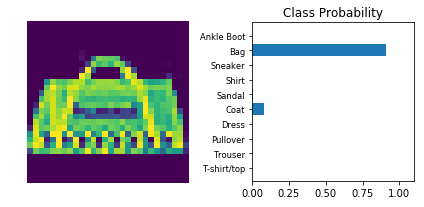

In [24]:
load_model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0].resize(1,3,28,28)

# Calculate the class probabilities (softmax) for img
output = load_model.forward(Variable(img))
ps = torch.exp(output)

# Plot the image and probabilities
viewer.view_classify(img.resize_(1, 28, 28), ps)